<a href="https://colab.research.google.com/github/AhanR/Maximl-internship-task/blob/main/tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev
! pip install pyTesseract tesseract

In [8]:
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import pytesseract as pt
from pytesseract import Output
pt.pytesseract.tesseract_cmd = ( r'/usr/bin/tesseract' )

# First Problem statement
Anagram grouping

In [ ]:
words = ["abcd", "dbca", "xyz", "def", "zyx", "cadb", "aabcd","ghi","cabda","abaa","abba"]

def execute_part1(words):
  res = {}
  # create a hash and add it to the dict with the other words with the same hash or create new entry if the hash is new
  for word in words:
    hash = wordHash(word)
    if hash in res:
      res[hash].append(word)
    else:
      res[hash] = [word]
  for key in res:
    print(" ".join(res[key]))

# create a character index based hashing technique
def wordHash(word):
  # the 0 is the frequency of the corresponding character appearing in the word
  # every index can be converted to a letter starting at index 0-> character 'a'
  hash = [0]*26
  for c in word:
    hash[ord(c)-ord("a")] += 1
  return str(hash)

In [ ]:
execute_part1(words)

abcd dbca cadb
xyz zyx
def
aabcd cabda
ghi
abaa
abba


# Second Problem Statement
Video manipulation using cv2

In [ ]:
def execute_part2(inputFile, outputFile = "/content/part2_output.mp4"):
  # VIDEO_FILE -> the input video file
  # VIDEO_OUT -> the file to be written to
  VIDEO_FILE = inputFile
  VIDEO_OUT = outputFile

  # the hard upper bound below which the video does not need to be edited
  UPPER_BOUND = 25

  # cap -> video stream object
  cap = cv2.VideoCapture(VIDEO_FILE)

  # all the video properties
  # n_frames -> number of frames in the video
  # in_fps -> frames per second of the video
  n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  in_fps = cap.get(cv2.CAP_PROP_FPS)
  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # out_fps -> frames per second to be set in the output video (20 by default) or lower if the source video has lower than 25 fps
  # codec -> the codec used to encode the video, other available options are MP4V
  # fourcc -> fourcc codec code
  # out -> the output stream
  out_fps = 20 if in_fps > UPPER_BOUND else in_fps
  codec = 'DIVX'
  fourcc = cv2.VideoWriter_fourcc(*codec)
  out =  cv2.VideoWriter(VIDEO_OUT, fourcc, out_fps, (width, height))

  print("INPUT VIDEO STATS:")
  print(f"frames : {n_frames} fps : {in_fps:0.2f} len : {n_frames/in_fps}")
  print(f"w : {width} h : {height}")
  print()
  print("OUTPUT SETTINGS:")
  print(f"fps : {out_fps} codec : {codec} filePath : {VIDEO_OUT}")
  print()

  # the time is in milli seconds
  # tx -> the time taken per frame in the input video (source video)
  # ty -> the time taken per fram in the output video (target video)
  tx = 1000/in_fps 
  ty = 1000/out_fps

  # outFrameNumber -> tracks the number of frames written to the target
  # directOutFlag -> sets to true when we need to pass the video as is, i.e. when in_fps < 25
  outFrameNumber = 0
  directOutFlag = False if in_fps > UPPER_BOUND else True

  for frame in tqdm(range(n_frames)):
    # ret -> tells us if the next frame was read or not (True if successful and False if no more frames or not successful)
    # img -> the next frame as an image
    ret, img = cap.read()
    if ret == False:
      print("Operation Aborted")
      break
    # converting from BGR to GRAYSCALE and back to get the greyscale image in BGR colour space
    # adding in text
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = cv2.putText(img, "Open CV", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0))

    # if direct out is set, push data to out stream or else check if current frame must be sampled
    if directOutFlag or outFrameNumber*ty <= frame*tx:
      # write to output
      # increment the total number of frames sampled (outFrameNumber)
      out.write(img)
      outFrameNumber+=1

  out.release()
  cap.release()
  print(f"\nWritten frames {outFrameNumber}")

  print()

  # some video stats for the new video file to cross check some values
  cap = cv2.VideoCapture(VIDEO_OUT)
  final_fps = cap.get(cv2.CAP_PROP_FPS)
  n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print("OUTPUT VIDEO STATS:")
  print(f"frames : {n_frames} fps : {final_fps} len : {n_frames/final_fps}")

In [ ]:
execute_part2("/content/input4.mp4")

INPUT VIDEO STATS:
frames : 4053 fps : 30.00 len : 135.1
w : 1280 h : 542

OUTPUT SETTINGS:
fps : 20 codec : DIVX filePath : /content/part2_output.mp4



100%|██████████| 4053/4053 [00:37<00:00, 109.48it/s]


Written frames 2702

OUTPUT VIDEO STATS:
frames : 2702 fps : 20.0 len : 135.1


# Third Problem Statement
OCR with bounding box

In [45]:
def execute_part3(filePath):
  # page segmentation mode (--psm) 5 is useful for reading vertical texts
  # page segmentation mode (--psm) 11 is useful for reading sparse horizontal texts
  # the OCR engine mode (--ocm) and languages (-l)
  config5 = r"--psm 5 --oem 1 -l ara+ben+chi_sim+eng+equ+hin+kan+rus load_system_dawg 0"
  config11 = r"--psm 11 --oem 1 -l ara+ben+chi_sim+eng+equ+hin+kan+rus load_system_dawg 0"

  # read the image and create a copy to edit and annotate over
  img = cv2.imread(filePath)
  imgOut = img.copy()

  # first pass, with mode 6 for horizontal text
  data = pt.image_to_data(img, config = config11, output_type = Output.DICT)
  # the best confidence value turns out to be 80% for this more in my testing
  # we add in a bounding rectangle
  # we add the text on the top left corner of the box
  # we add the confidence score at the bottom right of the box
  for i in range(len(data["text"])):
    if data["conf"][i] < 80:
      continue
    x,y = data["left"][i] , data["top"][i]
    xb,yb = x+data["width"][i] , y+data["height"][i]
    imgOut = cv2.rectangle(imgOut, (x,y), (xb,yb), (0,255,0), 3)
    imgOut = cv2.putText(imgOut, data["text"][i], (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    imgOut = cv2.putText(imgOut, str(data["conf"][i])+"%", (xb-30,yb+5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

  # second pass to get all the vertical data that was missed by previous pass
  data = pt.image_to_data(img, config = config5, output_type = Output.DICT)
  # the best confidence value turns out to be 90% for this more in my testing, also the case when the text is "??" is most likely incorrect,so I discard it
  # we add in a bounding rectangle
  # we add the text on the top left corner of the box
  # we add the confidence score at the bottom right of the box
  for i in range(len(data["text"])):
    if data["conf"][i] < 90 or "??" in data["text"][i]:
      continue
    x,y = data["left"][i] , data["top"][i]
    xb,yb = x+data["width"][i] , y+data["height"][i]
    imgOut = cv2.rectangle(imgOut, (x,y), (xb,yb), (0,255,0), 3)
    imgOut = cv2.putText(imgOut, data["text"][i], (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    imgOut = cv2.putText(imgOut, str(data["conf"][i])+"%", (xb-30,yb+5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

  # finally showing the image and all the annotations
  cv2_imshow(imgOut)

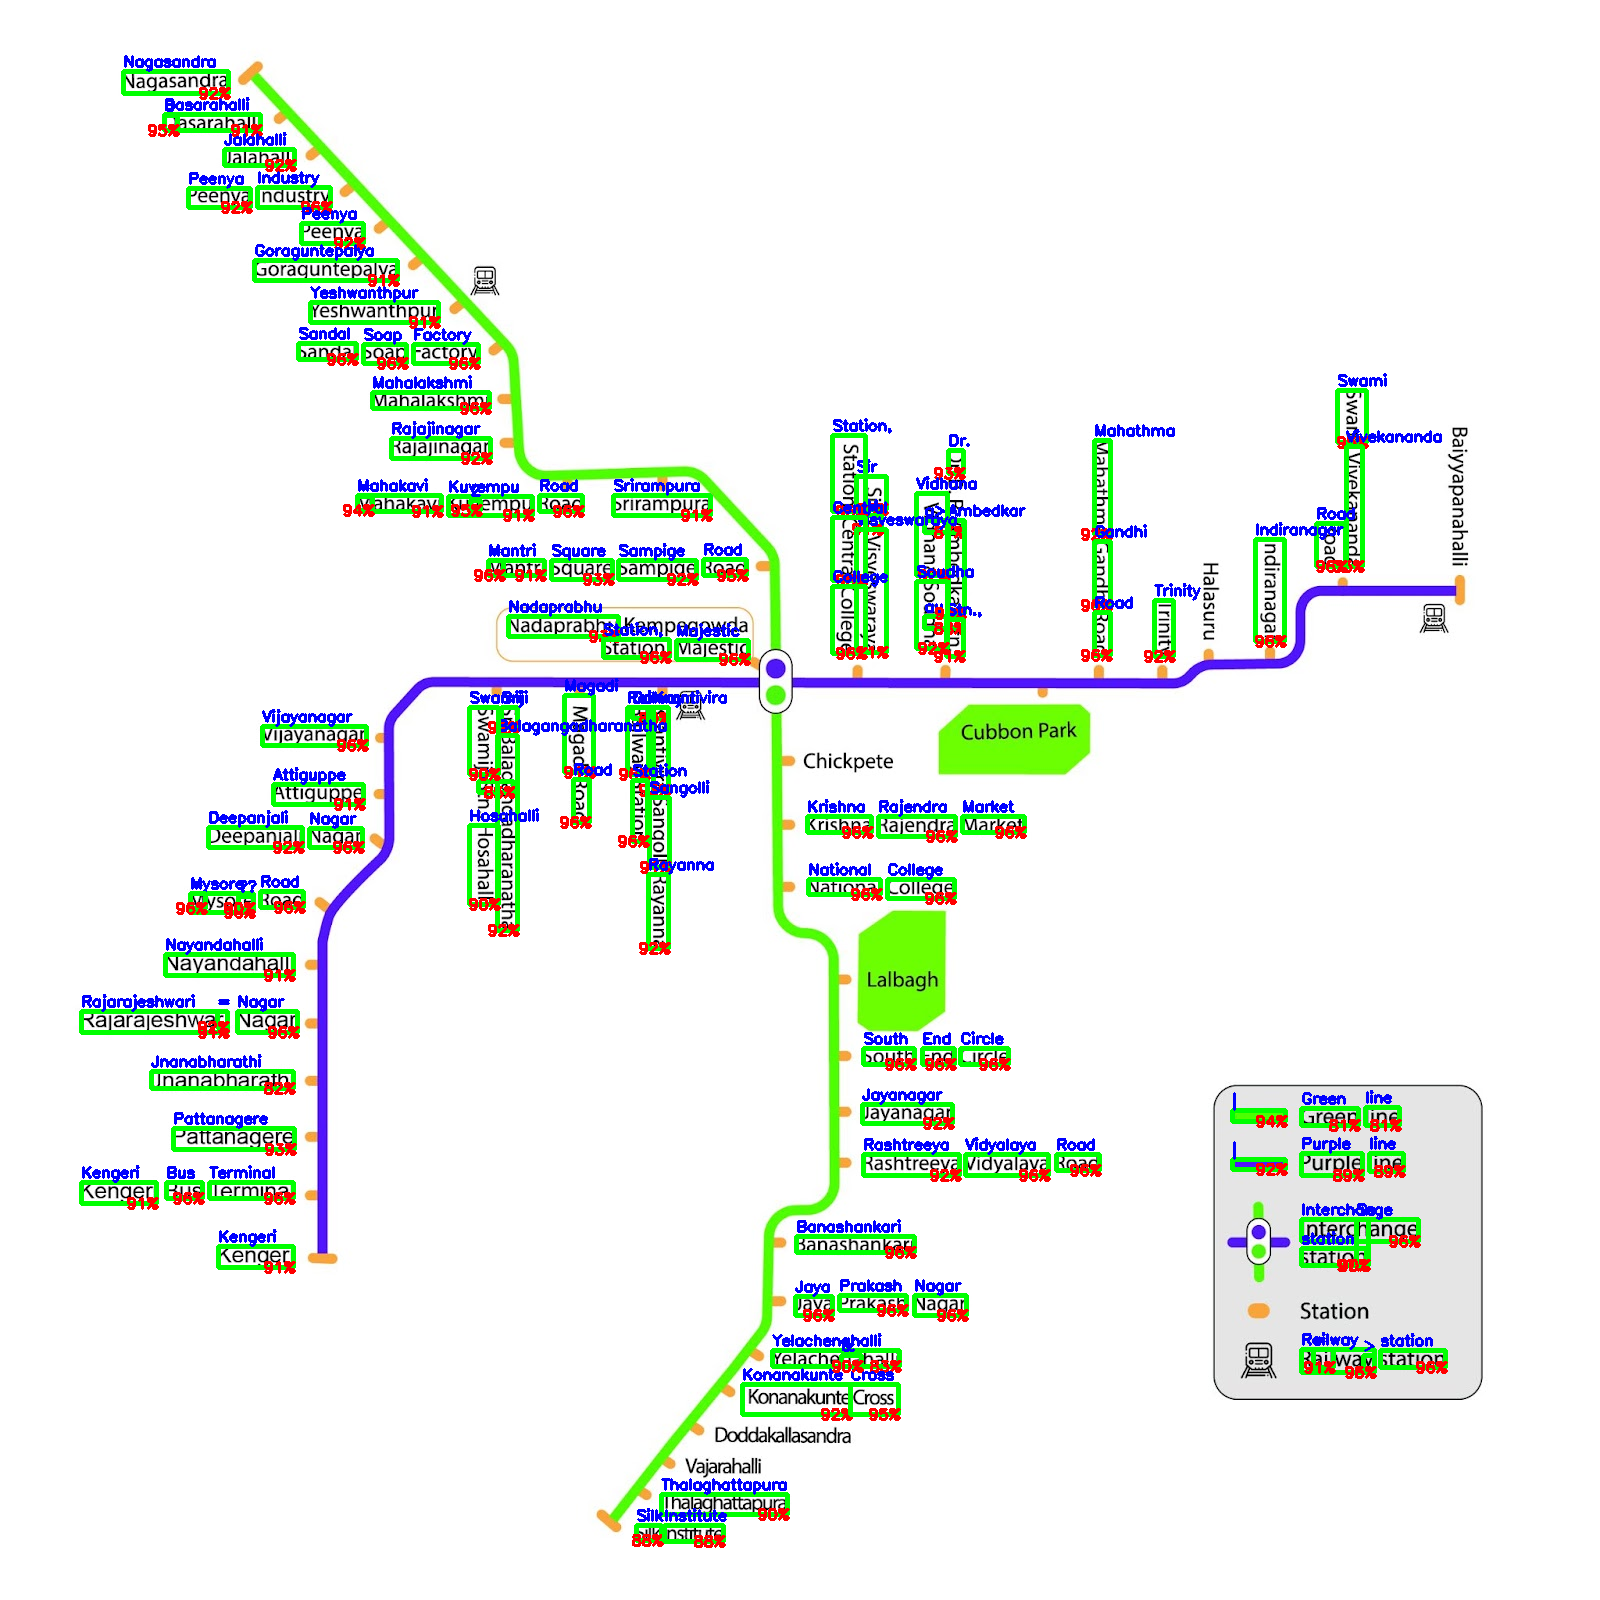

In [49]:
execute_part3("/content/input8.jpeg")

All the problems have been solved in under 7 hours.
Thanks for the opportunity